### Creating Simple Strategies

`TODO: Write some introductions for the following topics. Need to decide what the target audience for this notebook is so I can get full marks from English prof jk.`

#### Backtesting Philosophy

#### Beware: Overfitting

#### Training, Testing, and Validation Sets

#### TST: Market-Neutral, Medium Holding Strategies

Explain the trading strategies of TST.

#### Sample Strategy: 1d_fwd_return

We can get access to historical prices through links such as [this one](https://coinmarketcap.com/currencies/ripple/historical-data/?start=20171104&end=20180204).

The format of this data is quite easy to copy-and-paste, so it is unneccessary to write a web scraper at the moment. Data can be saved into the following format.

In [1]:
%%bash

head xrp_daily.dat


Date	Open	High	Low	Close	Volume	Market Cap
Feb 03, 2018	0.891992	0.974799	0.761635	0.924043	1,988,960,000	34,795,900,000
Feb 02, 2018	0.960642	0.960642	0.635185	0.884784	3,529,760,000	37,473,900,000
Feb 01, 2018	1.16	1.16	0.930378	0.962530	1,410,420,000	44,971,500,000
Jan 31, 2018	1.13	1.19	1.04	1.16	1,264,030,000	43,800,800,000
Jan 30, 2018	1.33	1.33	1.13	1.14	1,134,640,000	51,452,400,000
Jan 29, 2018	1.40	1.41	1.30	1.32	1,073,680,000	54,204,300,000
Jan 28, 2018	1.22	1.44	1.22	1.40	1,327,360,000	47,412,500,000
Jan 27, 2018	1.22	1.24	1.19	1.22	689,101,000	47,180,200,000
Jan 26, 2018	1.31	1.33	1.14	1.22	2,037,570,000	50,706,400,000


We want to move this data into a more analytics-friendly format by moving in into standard CSV formatting.

In [2]:
from datetime import datetime

import pandas as pd

df = pd.read_csv('xrp_daily.dat', sep='\t').infer_objects()
df = df.rename(index=str, columns={"Date": "date", "Open": "open", "High": "high", "Low": "low", 
                              "Close": "close", "Volume": "volume", "Market Cap": "mktcap"})

df.volume = df.volume.apply(lambda v: int(v.replace(',', '')))
df.mktcap = df.mktcap.apply(lambda m: int(m.replace(',', '')))
df.date = df.date.apply(lambda d: datetime.strptime(d, "%b %d, %Y").strftime("%Y-%m-%d"))
df = df.iloc[::-1].reset_index(drop=True)

df.to_csv("/Users/lola/xrp_daily.csv", index=False)
df.tail()

,date,open,high,low,close,volume,mktcap
363,2018-01-30,1.330000,1.330000,1.130000,1.140000,1134640000,51452400000
364,2018-01-31,1.130000,1.190000,1.040000,1.160000,1264030000,43800800000
365,2018-02-01,1.160000,1.160000,0.930378,0.962530,1410420000,44971500000
366,2018-02-02,0.960642,0.960642,0.635185,0.884784,3529760000,37473900000
367,2018-02-03,0.891992,0.974799,0.761635,0.924043,1988960000,34795900000


_This section is in progress. Please scroll to the next italicized text_

Before we train models on this data, we should first identify clusters within our dataset to determine which subsets of data we want to train on.

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


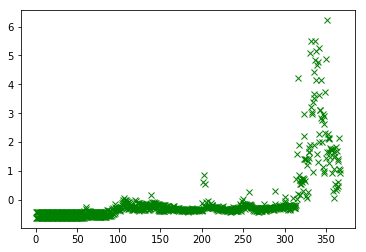

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing


#plt.hist(df.mktcap, bins=20)
#plt.show()

x = df[['volume', 'mktcap']].values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
df2 = pd.DataFrame(x_scaled, columns=['volume', 'mktcap'])
plt.plot(df2, 'gx')

_Continue Reading_

For each coin, we will subset its pricing history for relevant training data. We will partition a small amount into the test set, and run validation testing with mock trails on live data. Performance on live data will indicate whether or not strategies should be implemented in production. 

In [4]:
# close_1d.close.sub(df.close.iloc[1:])

print(df.iloc[-5:], '\n\n', (df.close.diff() / df.close)[-10:])
perc_change_1d = (df.close.diff() / df.close)

print(perc_change_1d.head())
print(perc_change_1d.tail())
# TODO: Fix offsets


           date      open      high       low     close      volume  \
363  2018-01-30  1.330000  1.330000  1.130000  1.140000  1134640000   
364  2018-01-31  1.130000  1.190000  1.040000  1.160000  1264030000   
365  2018-02-01  1.160000  1.160000  0.930378  0.962530  1410420000   
366  2018-02-02  0.960642  0.960642  0.635185  0.884784  3529760000   
367  2018-02-03  0.891992  0.974799  0.761635  0.924043  1988960000   

          mktcap  
363  51452400000  
364  43800800000  
365  44971500000  
366  37473900000  
367  34795900000   

 358   -0.038168
359   -0.073770
360    0.000000
361    0.128571
362   -0.060606
363   -0.157895
364    0.017241
365   -0.205157
366   -0.087870
367    0.042486
Name: close, dtype: float64
0         NaN
1   -0.010975
2    0.000772
3    0.002773
4   -0.007762
Name: close, dtype: float64
363   -0.157895
364    0.017241
365   -0.205157
366   -0.087870
367    0.042486
Name: close, dtype: float64


Slope: -0.06217673391831772, Intercept0.007488824006664108


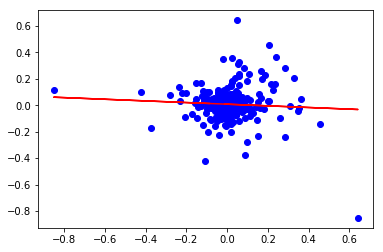

In [5]:
x, y = perc_change_1d[1:-1], perc_change_1d[2:]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f'Slope: {slope}, Intercept{intercept}')

plt.plot(x, y, "bo")
plt.plot(x, intercept + slope*x, 'r')
plt.show()

Slope: -0.06005401513748232, Intercept0.007391156512576657


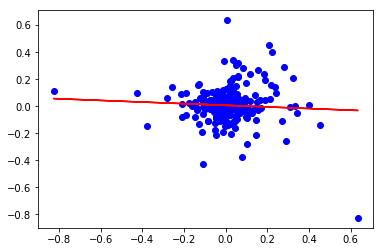

In [6]:
# We try the same methodology with Open prices:

perc_change_1d = (df.open.diff() / df.open)

x, y = perc_change_1d[1:-1], perc_change_1d[2:]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f'Slope: {slope}, Intercept{intercept}')

plt.plot(x, y, "bo")
plt.plot(x, intercept + slope*x, 'r')
plt.show()

From here, we can see that 1-dforward returns have a slightly negative correlation with future returns. This suggests that reversion-based strategies may be more rewarding on the 1-day time horizion.

We can encapsulate the functionality of the above code as follows:

Slope: 0.2677781870316172, Intercept: 0.029761632415845042, r_value: 0.2637875323775773


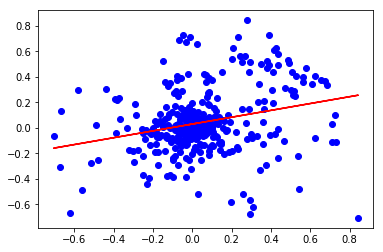

In [7]:
def nday_fwd_returns(data, n):
    delta_nd = data.diff(n) / data
    x, y = delta_nd[n:-n], delta_nd[2*n:]    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f'Slope: {slope}, Intercept: {intercept}, r_value: {r_value}')
    plt.plot(x, y, "bo")
    plt.plot(x, intercept + slope*x, 'r')
    plt.show()
    
nday_fwd_returns(df.close, 6)

We see that we get the strongest correlation for forward returns when $n = 6$.